# Deep learning for computer vision

Build and train convolutional networks for image recognition using CIFAR

In [1]:
import os
import sys
import pickle
import numpy as np
import torch
from torch import nn
from torch import Tensor
from torch.utils.data.dataset import Dataset
from torchvision import transforms

from Model import CIFAR_NN
from Model import CIFAR_CNN

from DataLoader import *

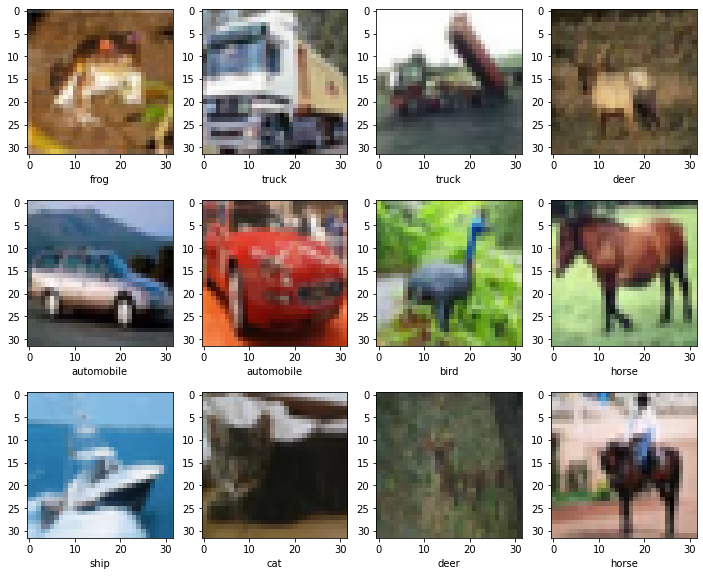

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader,Sampler

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

dataPath = "/Users/czkaiweb/Research/DeepVision/dataset/cifar-10-batches-py"

testPath = os.path.join(dataPath,"test_batch")
trainPath = [os.path.join(dataPath,"data_batch_%i"%i) for i in range(1,6)]

dataset = CIFAR(path = trainPath)
testset = CIFAR(path = testPath)

batch_size = 50
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=testset, shuffle=True, drop_last=True)

def display(dataset = None):
    plt.figure(figsize=[12,10])
    for step, data in enumerate(dataset,0):
        img,label = data
        # To display, color lay should be the last index
        img  = np.transpose(img, [1,2,0])
        #img = transforms.ToPILImage(img)
        plt.subplot(3,4,step+1)
        plt.xlabel(class_names[label])
        plt.imshow(img)
        if step == 11:
            break
            
display(dataset)

In [ ]:
model = CIFAR_NN()

opt = torch.optim.SGD(model.parameters(), lr=1e-2)
crossentropy = nn.CrossEntropyLoss()



In [ ]:
loss_history = []
val_accuracy = []
def train(epoch):
    maxstep = 0
    epoch_loss = 0
    n_batches = len(dataset)//batch_size
    for step,data in enumerate(train_loader,0):
        train_x, train_y = data
        x = torch.tensor(train_x,dtype=torch.float32)
        y = torch.tensor(train_y,dtype=torch.float32)
        y_pred = model.forward(x)
        y_pred = y_pred.view(-1,10)
        # compute loss
        loss = crossentropy(y_pred,y.long()).mean()
        epoch_loss += loss.item()
        
        # compute gradients
        loss.backward()
        
        # adam step
        opt.step()
        
        # clear gradients
        opt.zero_grad()
        
    
    epoch_loss = epoch_loss / n_batches
    loss_history.append(epoch_loss)
    epoch_loss = 0
    
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader,0):
            img,label = data
            output = model.forward(img)
            _,predict = torch.max(output.data,1)
            filterList = (predict == label)
            correct += filterList.sum().data
            total   += len(filterList)
            if i == 500:
                break
    accu = float(correct)/total
    val_accuracy.append(accu)
    print("Epoch {}, loss {} Accurancy: {}".format(epoch, epoch_loss, accu))
                  
for epoch in range(1, 50):
    train(epoch)
    plt.plot(val_accuracy)

In [3]:
cnn_model = CIFAR_CNN()
opt_cnn = torch.optim.Adam(cnn_model.parameters())
crossentropy_cnn = nn.CrossEntropyLoss()

In [15]:
# Setting up the training procedure
cnn_loss_history = []
cnn_val_accuracy = []
def cnn_train(epoch, model = None, opt = None, loss = None, train = None, test = None):
    maxstep = 0
    epoch_loss = 0
    n_batches = len(dataset)//batch_size
    train_loader = train
    test_loader = test

    if train_loader == None:
        print("No DataLoader for training... Terminated")
        return
    if opt == None:
        print("No Optimization methods set... Terminated")
        return
    if loss == None:
        print("No Loss function set... Terminated")
        return
    for step,data in enumerate(train_loader,0):
        train_x, train_y = data
        x = torch.tensor(train_x,dtype=torch.float32)
        y = torch.tensor(train_y,dtype=torch.float32)
        if len(y) < batch_size:
            continue
        y_pred = model.forward(x)
        y_pred = y_pred.view(-1,10)
        # compute loss
        loss = crossentropy_cnn(y_pred,y.long()).mean()
        epoch_loss += loss.item()
        
        # compute gradients
        loss.backward()
        
        # adam step
        opt.step()
        
        # clear gradients
        opt.zero_grad()
        
    
    epoch_loss = epoch_loss / n_batches
    cnn_loss_history.append(epoch_loss)
    epoch_loss = 0
    
    if test_loader == None:
        print("Epoch {}, loss {} Accurancy: N/A , skipping validation...".format(epoch, epoch_loss))
        return
    
    correct = 0
    total = 0
    with torch.no_grad():     
        for i, data in enumerate(test_loader,0):
            img,label = data
            model.eval()
            output = model.forward(img)
            _,predict = torch.max(output.data,1)
            filterList = (predict == label)
            correct += filterList.sum().data
            total   += len(filterList)
            if i == 500:
                break
    accu = float(correct)/total
    cnn_val_accuracy.append(accu)
    print("Epoch {}, loss {} Accurancy: {}".format(epoch, epoch_loss, accu))
                

In [5]:
# Make the training for CNN
for epoch in range(1, 50):
    cnn_train(epoch = epoch, model = cnn_model, opt = opt_cnn, loss = crossentropy_cnn, train = train_loader, test=test_loader)
plt.plot(cnn_val_accuracy)

/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1, loss 0 Accurancy: 0.4530938123752495


KeyboardInterrupt: 

In [16]:
# Setting up for CNN with BatchNorm
cnn_model_norm = CIFAR_CNN(useBatchNorm = True)
opt_cnn_norm = torch.optim.Adam(cnn_model_norm.parameters())
crossentropy_cnn = nn.CrossEntropyLoss()

In [17]:
for epoch in range(1, 50):
    cnn_train(epoch = epoch, model = cnn_model_norm, opt = opt_cnn_norm, loss = crossentropy_cnn, train = train_loader, test=test_loader)
plt.plot(cnn_val_accuracy)

/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1, loss 0 Accurancy: 0.6147704590818364
Epoch 2, loss 0 Accurancy: 0.624750499001996
Epoch 3, loss 0 Accurancy: 0.626746506986028
Epoch 4, loss 0 Accurancy: 0.6307385229540918
Epoch 5, loss 0 Accurancy: 0.6227544910179641
Epoch 6, loss 0 Accurancy: 0.6686626746506986
Epoch 7, loss 0 Accurancy: 0.624750499001996
Epoch 8, loss 0 Accurancy: 0.6207584830339321
Epoch 9, loss 0 Accurancy: 0.626746506986028
Epoch 10, loss 0 Accurancy: 0.6586826347305389
Epoch 11, loss 0 Accurancy: 0.590818363273453
Epoch 12, loss 0 Accurancy: 0.5968063872255489
Epoch 13, loss 0 Accurancy: 0.6347305389221557
Epoch 14, loss 0 Accurancy: 0.6127744510978044
Epoch 15, loss 0 Accurancy: 0.5988023952095808
Epoch 16, loss 0 Accurancy: 0.5988023952095808
Epoch 17, loss 0 Accurancy: 0.5868263473053892
Epoch 18, loss 0 Accurancy: 0.6167664670658682
Epoch 19, loss 0 Accurancy: 0.562874251497006
Epoch 20, loss 0 Accurancy: 0.6227544910179641
Epoch 21, loss 0 Accurancy: 0.6067864271457086
Epoch 22, loss 0 Accurancy: 

KeyboardInterrupt: 

In [21]:
# Data Augmentation:
# data preprocessing and flipping

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.RandomCrop((32,32),padding=4),  # Randomly crop with size = 32*32 after padding 4 pixels on the margin
    transforms.RandomRotation([-30,30]), # Apply Random rotation between [-30,30] with resampling methods
    transforms.RandomHorizontalFlip(),    # Make horizontal flip with p=0.5(default)
    transforms.ToTensor(),
    transforms.Normalize(means, stds),   # Means and stds are pre-calculated with sample set for each channel
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),   # Means and stds are pre-calculated with sample set for each channel
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

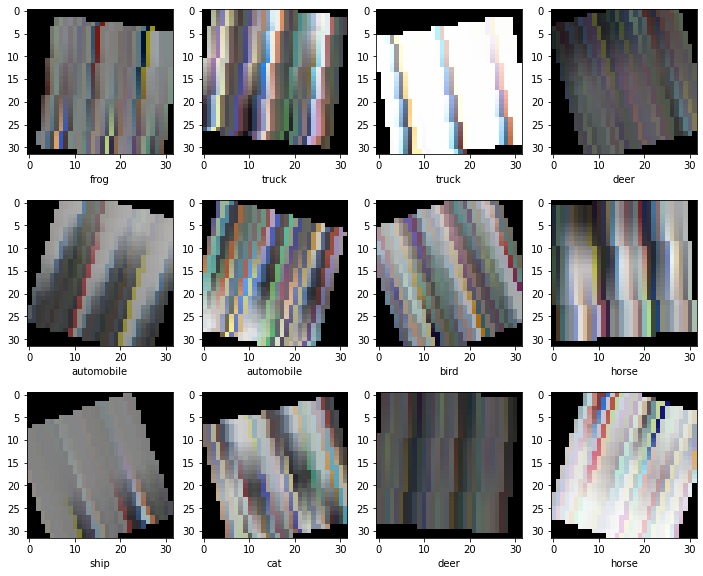

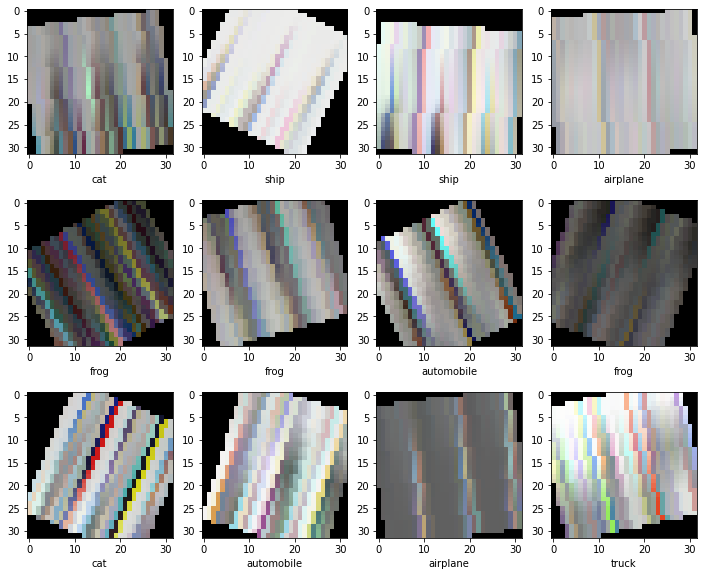

In [30]:
dataset_aug = CIFAR(path = trainPath, transform=transform_augment)
train_loader_aug = DataLoader(dataset=dataset_aug, batch_size=batch_size, shuffle=True, drop_last=True)

test_aug = CIFAR(path = testPath, transform=transform_augment)
test_loader_aug = DataLoader(dataset=test_aug, shuffle=True, drop_last=True)



def display(dataset = None):
    plt.figure(figsize=[12,10])
    for step, data in enumerate(dataset,0):
        img,label = data
        # To display, color lay should be the last index
        img  = np.transpose(img, [1,2,0])*stds+means
        #img = transforms.ToPILImage(img)
        plt.subplot(3,4,step+1)
        plt.xlabel(class_names[label])
        plt.imshow(img)
        if step == 11:
            break

display(dataset_aug)
display(test_aug)


In [31]:
cnn_loss_history = []
cnn_val_accuracy = []

opt_cnn_norm = torch.optim.Adam(cnn_model_norm.parameters())
crossentropy_cnn = nn.CrossEntropyLoss()

for epoch in range(1, 21):
    cnn_train(epoch = epoch,model = cnn_model_norm, opt = opt_cnn_norm, loss = crossentropy_cnn, train= train_loader_aug, test = test_loader_aug)
plt.plot(cnn_val_accuracy)

/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/anaconda3/envs/Erdos/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1, loss 0 Accurancy: 0.12375249500998003
Epoch 2, loss 0 Accurancy: 0.10379241516966067
Epoch 3, loss 0 Accurancy: 0.10179640718562874
Epoch 4, loss 0 Accurancy: 0.09580838323353294
Epoch 5, loss 0 Accurancy: 0.10778443113772455
Epoch 6, loss 0 Accurancy: 0.09580838323353294
Epoch 7, loss 0 Accurancy: 0.11976047904191617


KeyboardInterrupt: 